In [78]:
import matplotlib.pyplot as plt
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import numpy as np
import pandas as pd
import joblib

#Loading swimmer videos
mat = loadmat('T9F1_H2O2_3v_3_trajs_imgdata_bigR.mat') 
mdata = mat['particles_new']  # variable in mat file
C = np.squeeze(mdata) #drop the dimensions of the cells


In [7]:
ERT_model = joblib.load("MBN19_ERT_model_final_nocat.pkl")
full_pipeline = joblib.load("pipeline_MBN19_Track_nocat.pkl")

In [79]:
#for loop fitting data - all particles
RI_corr = 1.333 #accounting for refractive index mismatch

dropped_labels = ["x","y","sum_peaks"]

num_attribs = ['moments', 'minmax_scaled', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40']  

Particles = [] #works as list for appending, can convert to array later
for i in range(len(C)):
    #load the particle in as dataframe for treatment
    particle = C[i].copy()
    X = pd.DataFrame(particle,
                  columns = ['x','y','moments', 'minmax_scaled', 'minpeaks', 'maxpeaks',
                             'sum_peaks', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40']
                 )
    x = X["x"].to_numpy()
    y = X["y"].to_numpy()
    X_num = X[num_attribs].copy()
    X_transform = full_pipeline.transform(X_num)
    Zlabels = ERT_model.predict(X_transform)
    Zlabels=-1*(Zlabels-20)*RI_corr #adjusting the Z - imaging from below, 20 um set, then account for correction factor
    #Particles.append([x,y,Zlabels])
    Particles.append(np.stack([x,y,Zlabels,i*np.ones(len(x))],axis=1)) #[x,y,z, particle ID]
    
    del Zlabels
    del X

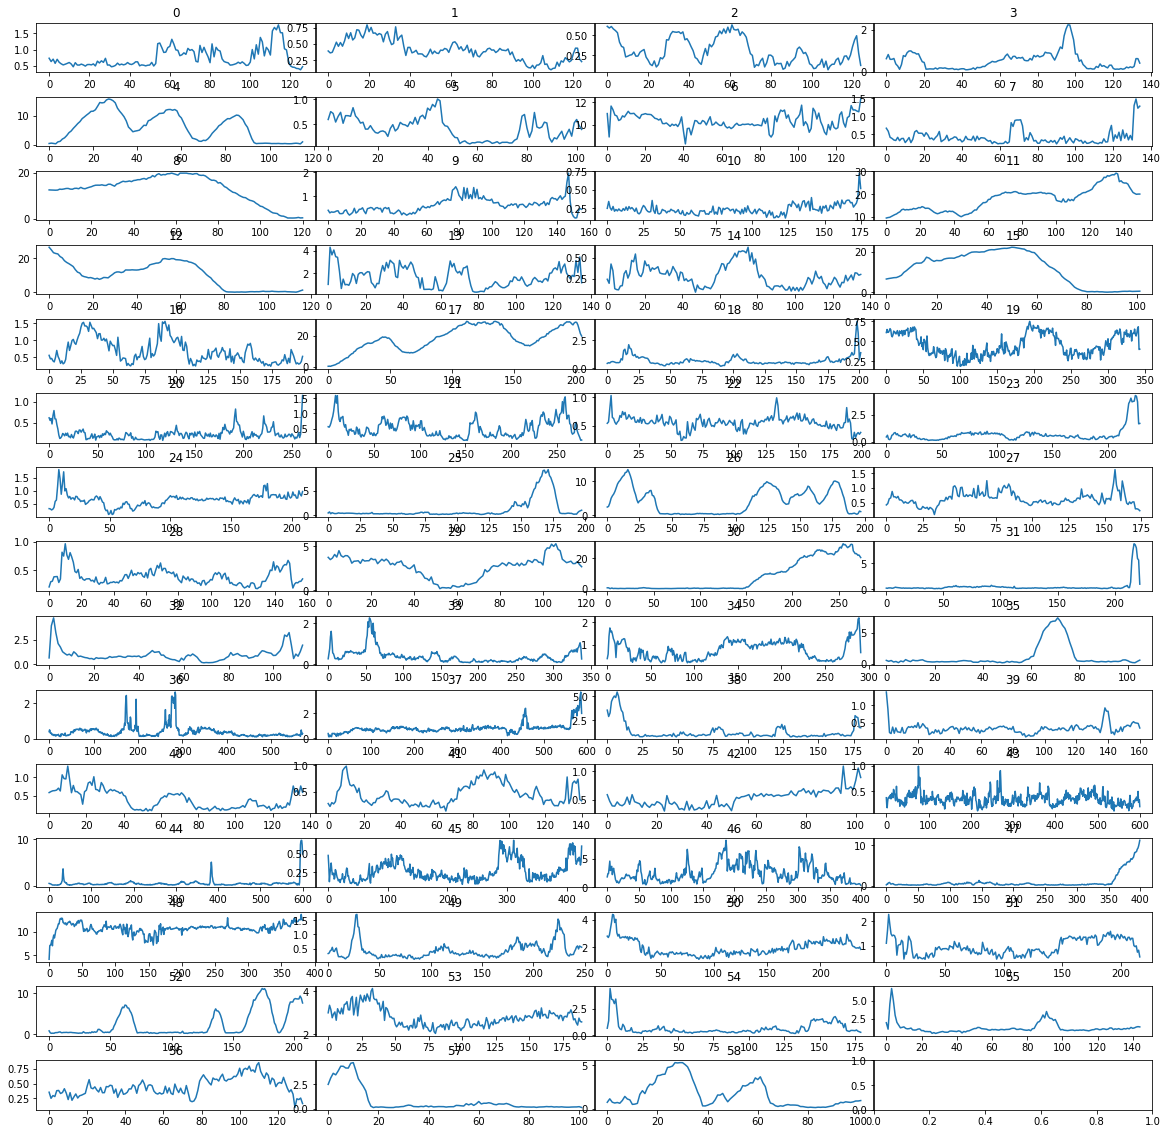

In [80]:
#next is to make subplots to check the Z vals, some might be poor and need to be removed
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(int(np.ceil(len(Particles)/4)),4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.flatten() #needed to make array 1D
#axs = axs.ravel()

for i in range(len(Particles)):

    axs[i].plot(Particles[i][:,2])
    axs[i].set_title(str(i))
    

In [81]:
#filtering out very noisy (by eye) 
verynoisy_pids = []
Particles_2 = [x for x in Particles if x[0,-1] not in verynoisy_pids] #remove particles identified as noisy

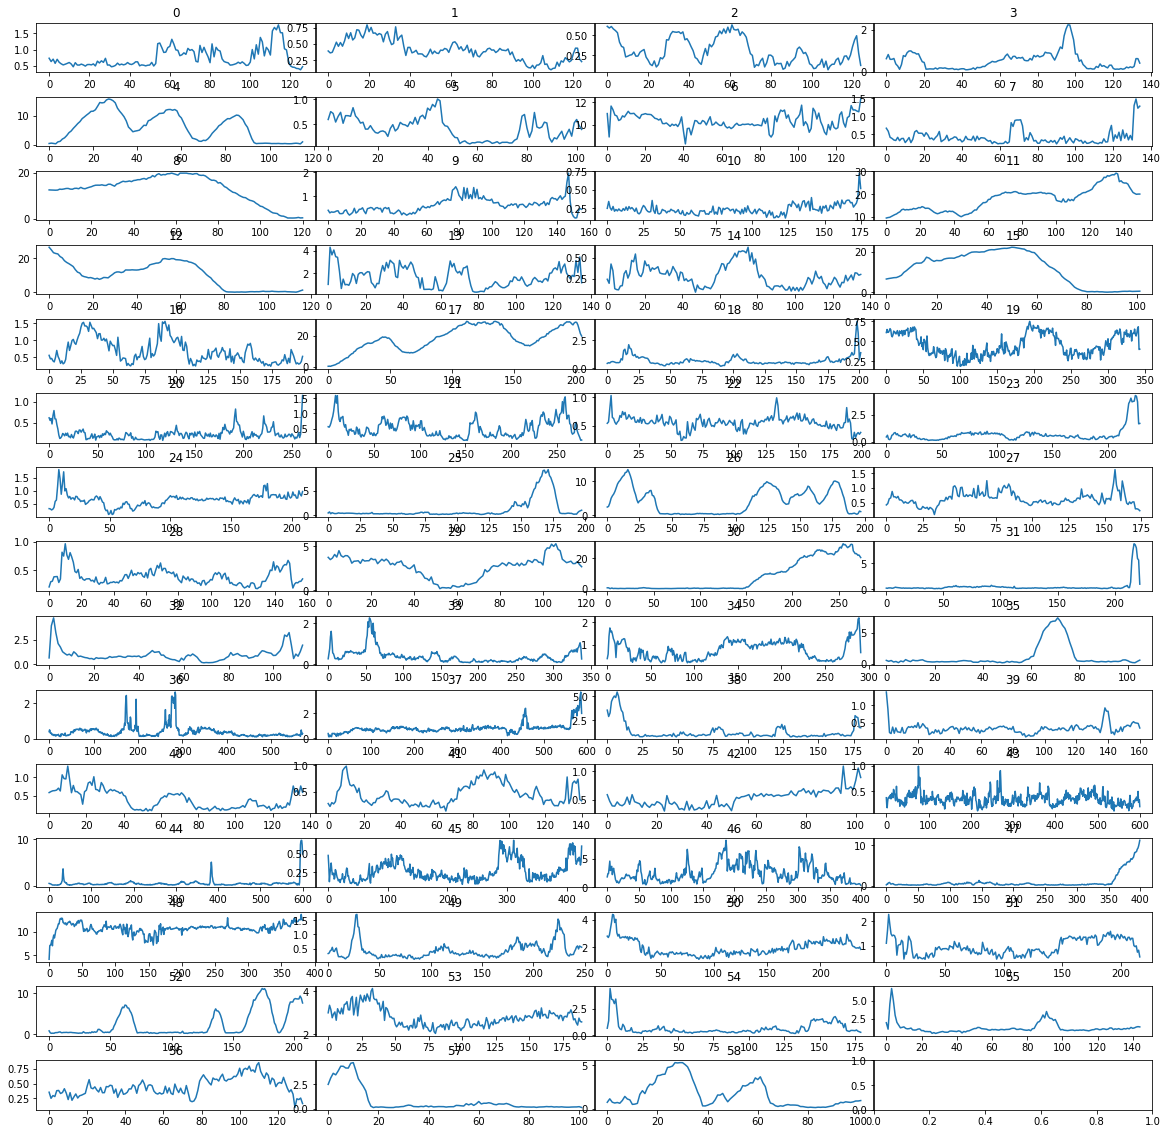

In [82]:
#Check the remaining particles - further filtering needed likely in scripts for analysis (e.g. by some quantitative metric)
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(int(np.ceil(len(Particles_2)/4)),4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.flatten() #needed to make array 1D
#axs = axs.ravel()

for i in range(len(Particles_2)):

    axs[i].plot(Particles_2[i][:,2])
    axs[i].set_title(str(i))

In [85]:
#saving out the Z trajs which by eye are ok - further filtering performed for velocity analysis etc.
from scipy.io import savemat

FrameStack = np.empty((len(Particles_2),), dtype=object)
for i in range(len(Particles_2)):
    FrameStack[i] = Particles_2[i]

savemat("MBN19_T9F1_H2O2_3v_3_bigR_nocat.mat", {"trajs":FrameStack})